In [1]:
import networkx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats 
import random
import time
import scipy.stats as stats

In [2]:
def erdos_renyi(n,average_degree):
    k = (average_degree*n)/2
    print("K is: ",k)
    nodes =  np.arange(1,n,dtype=np.int64)
    g = networkx.empty_graph(n)
    while(k>0):
        (node_i, node_j) = np.random.choice(nodes, 2, replace=False)
        while(g.has_edge(node_i,node_j)):
            (node_i, node_j) = np.random.choice(nodes, 2, replace=False)
        g.add_edge(node_i,node_j)
        k-=1
    return g

K is:  25000.0
      Node  Degree
0        0       0
1        1       8
2        2      10
3        3       1
4        4       5
...    ...     ...
9995  9995       5
9996  9996       8
9997  9997       7
9998  9998       4
9999  9999       6

[10000 rows x 2 columns]
Mean is:  5.0
Standar deviation is:  2.2292368536552973


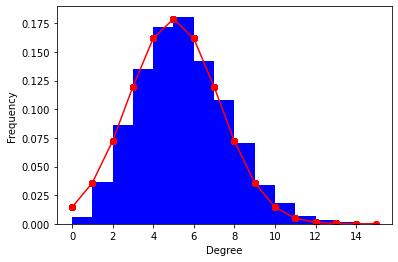

In [3]:
b = erdos_renyi(10000,5)
deg = b.degree()
pd_deg = pd.DataFrame(deg, columns=['Node', 'Degree'])
print(pd_deg)

In [6]:
def prob_calc(NG):
    nodes_probs = []
    t_degree= (2 * len(NG.edges()))
    for node in NG.nodes():
        node_degr = NG.degree(node)
        node_prob = node_degr / t_degree
        nodes_probs.append(node_prob)
    random_nodes = np.random.choice(NG.nodes(),4,p=nodes_probs,replace=False)
    return random_nodes

In [7]:
def barbasi_albert(n,init_nodes):
    new_node = init_nodes
    NG = networkx.empty_graph(init_nodes)
    NG.add_node(new_node)
    for i in range(0,3):
        NG.add_edge(i, i+1)
        if (i+1) == 4:
            NG.add_edge(i+1, 0)
    count = 1
    for node in range(n):
        new_node += 1
        NG.add_node(new_node)
        random_nodes=prob_calc(NG)
        for random_node in random_nodes:
            NG.add_edge(new_node,random_node)
    return NG
               

In [8]:
init_nodes = 0
g = barbasi_albert(10000,0)

5000.0
2887.0400066504103


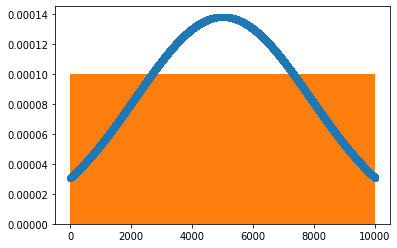

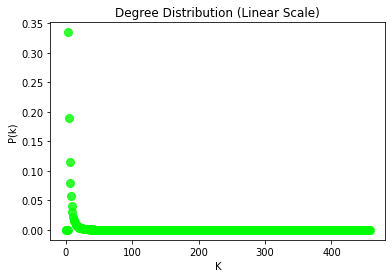

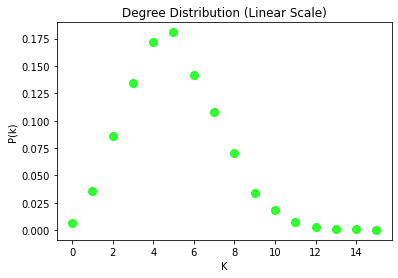

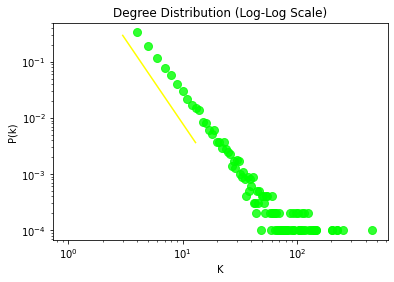

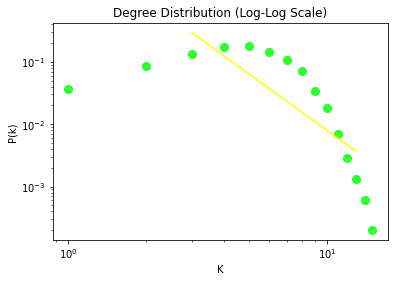

/opt/anaconda3/envs/ULB/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/anaconda3/envs/ULB/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


79.98647531318144
9751.0
None
inf
nan
alpha=  1.1123073098827487   sigma=  0.0011230169493837191


/opt/anaconda3/envs/ULB/lib/python3.7/site-packages/powerlaw.py:1178: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/opt/anaconda3/envs/ULB/lib/python3.7/site-packages/powerlaw.py:1798: RuntimeWarning: invalid value encountered in subtract
  ( (loglikelihoods1-loglikelihoods2) - mean_diff)**2


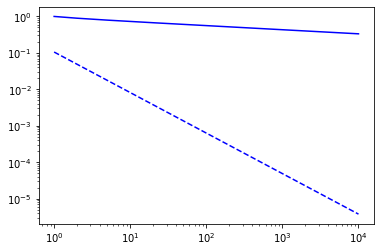

In [9]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import powerlaw


from plot import k_distribution
from plot import plot_exponential

# -----------------------------------
mu = np.mean(g)
sigma = np.std(g)
print(mu)
print(sigma)
fit = stats.norm.pdf(g, np.mean(g), np.std(g))
plt.plot(g, fit, '-o')
plt.hist(g, density=True)
plt.show()

# ---------------------------------

k_distribution(graph=g, color='#00ff00', alpha=.8)
k_distribution(graph=b, color='#00ff00', alpha=.8)
k_distribution(graph=g, color='#00ff00', scale='log', alpha=.8, low=3, high=14, expct_const=8)
k_distribution(graph=b, color='#00ff00', scale='log', alpha=.8, low=3, high=14, expct_const=8)

# ----------------------------
# plot_exponential(g, np.mean(g), np.std(g), color='blue', label='Scale Free')
# plt.legend()

# ----------------------------
fit = powerlaw.Fit(np.array(g) + 1, xmin=1, discrete=True)
fit.power_law.plot_ccdf(color='b', linestyle='-', label='fit ccdf')
fit.power_law.plot_pdf(color='b', linestyle='--', label='fit ccdf')

results = powerlaw.Fit(g)
print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.xmax)
R, p = results.distribution_compare('power_law', 'stretched_exponential')
print(R)
print(p)
print('alpha= ', fit.power_law.alpha, '  sigma= ', fit.power_law.sigma)



In [10]:
R=1 
P=0 
S=-0.05
#T=1.07
rounds = 2000
#print(dmax)
actions = [0,1] # 1:Cooperate | 0:Defect

In [11]:
def set_initial_attributes(g):
    networkx.set_node_attributes(g,None,'type')
    networkx.set_node_attributes(g,0, 'payoff')

In [12]:
def clear_payoffs(g):
    networkx.set_node_attributes(g,0, 'payoff')

In [13]:
def init_type(g):
    for node in g.nodes():
        random_selection=random.choices(population=actions,weights=[0.5,0.5])[0]
        g.nodes[node]['type']= random_selection

In [14]:
def get_payoff(i, j):
    payoff = i * j * R + i * (1 - j) * S  + (1 - i) * (j) * T + (1 - i) * (1 - j) * P
    return payoff

In [15]:
def set_payoff(g,node):
    total_payoff=g.nodes[node]['payoff']
    neighbors = [n for n in g.neighbors(node)]
    action_i = g.nodes[node]['type']
    for neighbor in neighbors:
        action_j = g.nodes[neighbor]['type']
        total_payoff += get_payoff(action_i,action_j)
    g.nodes[node]['payoff'] = total_payoff

In [16]:
def first_round(g):
    for node in g.nodes():
        set_payoff(g,node)

In [17]:
def  replicator_rule(g,node_i,node_j):
    wi = g.nodes[node_i]['payoff']
    wj = g.nodes[node_j]['payoff']
    if wi > wj:
        pij = 0
        return pij
    else:
        kmax = max(g.degree[node_i],g.degree[node_j])
        pij = (wj - wi) / ( kmax*dmax)   
        return pij

In [18]:
def play_game(g):
    init_type(g)
    vector = np.zeros(shape=(rounds), dtype=int)
    for round in range(rounds):
        clear_payoffs(g)
        first_round(g)
        for node_i in g.nodes():
            neighbors = [n for n in g.neighbors(node_i)]
            if len(neighbors) > 0:
                node_j = np.random.choice(neighbors)
                action_i = g.nodes[node_i]['type']
                action_j = g.nodes[node_j]['type']
                if action_i != action_j:
                    pij = replicator_rule(g,node_i,node_j)
                    next_action = random.choices(population=[action_j,action_i],weights=[pij,1-pij])[0]
                    g.nodes[node_i]['type'] = next_action
        temp_type = list(networkx.get_node_attributes(g,'type').values())
        c_counter = temp_type.count(1)
        vector[round] = c_counter
    print("Vector of Cooperators is: ",vector)
    return vector

Initializing for T:  1.6
Vector of Cooperators is:  [4236 3768 3439 ...  169  165  169]
Finished erdos with T=1.6
Vector of Cooperators is:  [4320 3906 3585 ... 4356 4363 4383]
Finished barabasi with T=1.6


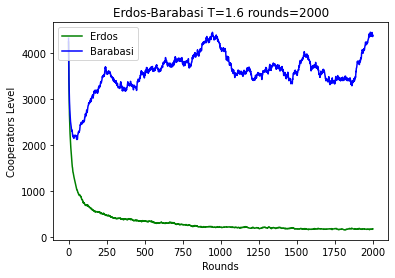

Time elapsed:  2543.929702281952
Initializing for T:  1.8
Vector of Cooperators is:  [3966 3477 3081 ...   29   29   29]
Finished erdos with T=1.8
Vector of Cooperators is:  [4245 3771 3445 ... 3337 3315 3330]
Finished barabasi with T=1.8


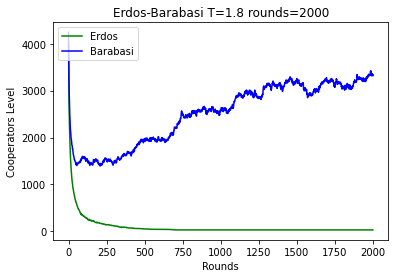

Time elapsed:  1537.097365140915
Initializing for T:  1.92
Vector of Cooperators is:  [4078 3557 3159 ...   31   31   31]
Finished erdos with T=1.92
Vector of Cooperators is:  [4104 3670 3323 ... 4375 4384 4405]
Finished barabasi with T=1.92


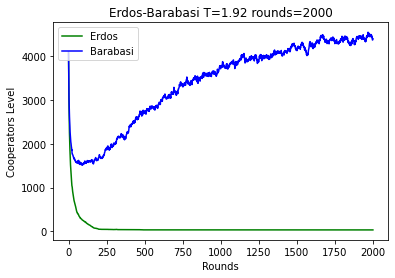

Time elapsed:  904.8317358493805
Initializing for T:  1.97
Vector of Cooperators is:  [4072 3557 3182 ...   27   27   27]
Finished erdos with T=1.97
Vector of Cooperators is:  [4158 3584 3191 ...  929  944  953]
Finished barabasi with T=1.97


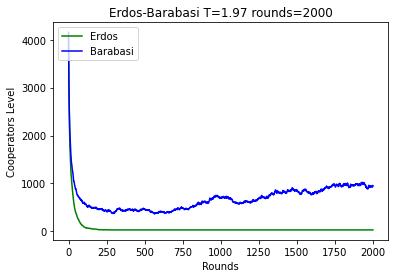

Time elapsed:  850.887542963028


In [19]:
#T_array = [1.02, 1.05,1.1, 1.2, 1.4, 1.6, 1.8, 1.92, 1.97]

for t in T_array:
    start = time.time()
    T = t
    #T = 1.03
    dmax = max(T,R) - min(S,P)
    print("Initializing for T: ",T)
    set_initial_attributes(b)
    c_players_erdos = play_game(b)
    print("Finished erdos with T={}".format(T))
    #print("C players for ERDOS: ",c_players_erdos)
    set_initial_attributes(g)
    c_players_barabasi = play_game(g)
    print("Finished barabasi with T={}".format(T))
    #print("C players for Barabasi: ",c_players_barabasi)
    plt.plot(c_players_erdos,color='g',label='Erdos')
    plt.plot(c_players_barabasi,color='b',label='Barabasi')
    plt.xlabel('Rounds')
    plt.ylabel('Cooperators Level')
    plt.legend(loc='upper left')
    plt.title('Erdos-Barabasi T={} rounds={}'.format(T,rounds))
    #plt.savefig('Erdos_Barbasi_T=1.03_1000.png')
    plt.savefig('Erdos_Barbasi_T={}_{}.png'.format(T,rounds))
    #files.download("Erdos_Barbasi_T={}_{}.png".format(T,rounds))
    plt.show()
    end = time.time()
    print("Time elapsed: ",end - start)

In [ ]:
simulations = 20
T_array = [(1.03,400), (1.07,800),(1.1,800), (1.2,800), (1.3,700), (1.5,700), (1.7,300), (1.9,300), (1.95,200)]
vector_average_b = np.zeros(shape=(len(T_array)), dtype=int)
vector_average_e = np.zeros(shape=(len(T_array)), dtype=int)
ct = 0
for t in T_array:
  counter_b = np.zeros(shape=(simulations), dtype=int)
  counter_e = np.zeros(shape=(simulations), dtype=int)
  start = time.time()
  for sim in range (simulations):   
    T = t[0]
    rounds = t[1]
    dmax = max(T,R) - min(S,P)
    print("Initializing for T: ",T)
    set_initial_attributes(b)
    c_players_erdos = play_game(b)
    print("Finished erdos with T={}".format(T))
    set_initial_attributes(g)
    c_players_barabasi = play_game(g)
    print("Finished barabasi with T={}".format(T))
    counter_b[sim] = c_players_barabasi[rounds-1]
    counter_e[sim] = c_players_erdos[rounds-1]
  vector_average_b[ct] = np.mean(counter_b) 
  vector_average_e[ct] = np.mean(counter_e)
  ct +=1
  end = time.time()
  print("Time elapsed={} for t={} ".format((end - start)/60,t[0]))
print("Finish")
print(vector_average_b)
print(vector_average_e)

Initializing for T:  1.03
Vector of Cooperators is:  [4483 4201 4005 3937 3877 3853 3860 3850 3836 3854 3864 3859 3854 3903
 3911 3931 3975 3993 4055 4066 4077 4090 4131 4173 4210 4242 4300 4322
 4335 4370 4419 4445 4498 4530 4551 4597 4651 4674 4693 4724 4754 4782
 4791 4856 4877 4964 5008 5047 5095 5139 5169 5186 5205 5261 5336 5368
 5412 5490 5548 5590 5643 5683 5693 5753 5784 5800 5862 5873 5911 5935
 5978 6025 6041 6095 6132 6166 6207 6214 6295 6318 6296 6370 6383 6416
 6436 6451 6489 6508 6579 6631 6656 6680 6716 6756 6762 6771 6794 6838
 6841 6888 6958 6975 7044 7055 7082 7103 7136 7167 7214 7223 7289 7302
 7311 7284 7293 7321 7333 7402 7400 7423 7452 7464 7490 7512 7540 7589
 7617 7631 7692 7713 7725 7758 7781 7791 7824 7819 7878 7858 7894 7918
 7953 7982 7965 7983 8005 8007 8030 8101 8104 8079 8094 8126 8115 8128
 8184 8187 8187 8230 8267 8263 8307 8325 8342 8333 8328 8348 8396 8416
 8440 8458 8468 8506 8505 8495 8513 8555 8550 8573 8571 8563 8584 8598
 8656 8637 8597 8597 862

Vector of Cooperators is:  [4521 4265 4108 4009 3950 3928 3916 3889 3895 3905 3925 3926 3943 3966
 4008 4070 4068 4100 4148 4192 4218 4288 4346 4379 4416 4408 4408 4462
 4495 4487 4535 4535 4569 4622 4706 4735 4796 4812 4880 4886 4946 4980
 5054 5074 5119 5150 5167 5267 5298 5350 5389 5427 5445 5525 5599 5638
 5652 5676 5657 5687 5746 5789 5812 5875 5854 5911 5933 5977 6002 6030
 6067 6127 6164 6174 6229 6263 6304 6313 6371 6413 6430 6459 6548 6520
 6553 6594 6620 6631 6637 6654 6689 6680 6743 6780 6808 6816 6849 6852
 6892 6934 7002 7011 7020 7044 7082 7116 7132 7149 7200 7226 7285 7286
 7305 7341 7380 7423 7424 7463 7489 7485 7524 7552 7615 7642 7694 7746
 7769 7791 7782 7816 7823 7844 7852 7870 7876 7901 7911 7930 7996 8007
 8051 8067 8088 8060 8069 8082 8078 8116 8126 8150 8135 8161 8156 8182
 8213 8210 8214 8240 8269 8267 8277 8318 8325 8359 8406 8427 8412 8444
 8448 8426 8424 8410 8434 8447 8481 8486 8511 8520 8530 8532 8550 8603
 8598 8572 8581 8604 8609 8636 8664 8656 8698 8697

Vector of Cooperators is:  [4474 4217 4103 3991 3893 3882 3879 3892 3909 3879 3860 3878 3922 3943
 3938 3982 4006 4066 4128 4169 4213 4251 4304 4394 4444 4508 4516 4507
 4546 4538 4561 4541 4588 4635 4687 4729 4736 4793 4820 4879 4925 4970
 5013 5023 5081 5170 5234 5234 5286 5372 5393 5402 5386 5429 5488 5537
 5607 5603 5645 5678 5733 5761 5822 5891 5902 5981 5977 5960 5961 5993
 6022 6017 6035 6116 6173 6192 6170 6212 6261 6284 6304 6332 6343 6391
 6436 6440 6475 6479 6494 6533 6584 6622 6664 6732 6769 6781 6797 6847
 6903 6899 6909 6957 6976 6995 7033 7043 7045 7062 7086 7143 7144 7134
 7185 7223 7201 7244 7297 7308 7297 7327 7336 7376 7446 7442 7452 7481
 7525 7521 7546 7570 7615 7598 7597 7605 7617 7634 7669 7715 7744 7767
 7777 7816 7835 7840 7874 7900 7918 7934 7932 7958 7960 8007 8037 8040
 8100 8094 8122 8110 8149 8201 8213 8243 8254 8271 8272 8263 8297 8283
 8299 8356 8377 8374 8386 8396 8391 8458 8454 8473 8520 8521 8533 8550
 8562 8599 8603 8642 8625 8647 8654 8708 8699 8754

Vector of Cooperators is:  [4454 4232 4036 3972 3933 3891 3909 3887 3880 3828 3807 3819 3834 3854
 3861 3892 3915 3927 3947 4019 4057 4086 4089 4097 4164 4192 4219 4248
 4266 4324 4344 4405 4459 4510 4543 4574 4588 4615 4649 4695 4778 4838
 4866 4869 4892 4947 4969 5021 5055 5111 5133 5163 5204 5235 5261 5290
 5343 5406 5431 5511 5549 5594 5595 5604 5665 5679 5755 5784 5779 5813
 5838 5878 5920 5981 6040 6060 6102 6129 6180 6211 6235 6267 6281 6312
 6371 6371 6410 6441 6446 6514 6572 6595 6628 6651 6672 6730 6780 6820
 6839 6855 6895 6908 6921 6937 6993 7013 7060 7128 7154 7174 7199 7244
 7229 7274 7258 7281 7342 7353 7370 7399 7428 7427 7476 7499 7513 7540
 7511 7546 7597 7629 7653 7673 7714 7746 7745 7754 7777 7782 7787 7826
 7841 7859 7884 7898 7911 7943 7979 7988 7997 8020 8050 8048 8066 8081
 8090 8104 8136 8160 8164 8169 8180 8216 8235 8231 8272 8309 8320 8358
 8374 8379 8382 8394 8405 8422 8417 8429 8434 8417 8463 8482 8510 8499
 8531 8552 8545 8560 8580 8595 8632 8658 8636 8660

Vector of Cooperators is:  [4511 4217 4082 4040 4012 3990 3959 3961 3960 3948 3944 3976 3993 4054
 4091 4108 4151 4188 4230 4275 4306 4333 4336 4382 4464 4478 4531 4535
 4568 4602 4640 4683 4768 4825 4841 4894 4922 4958 5040 5040 5122 5186
 5193 5216 5273 5290 5328 5357 5418 5403 5436 5467 5505 5524 5525 5563
 5623 5681 5735 5771 5806 5876 5932 5943 5938 5973 6033 6063 6091 6120
 6135 6165 6227 6259 6311 6344 6383 6395 6413 6451 6467 6471 6495 6552
 6563 6591 6627 6631 6653 6692 6719 6751 6754 6798 6830 6848 6887 6945
 6976 7034 7100 7118 7170 7181 7195 7172 7204 7240 7254 7281 7294 7351
 7384 7414 7484 7505 7517 7539 7542 7550 7623 7633 7627 7651 7684 7687
 7701 7717 7742 7752 7780 7817 7836 7873 7928 7941 7962 7986 8000 8000
 8016 8041 8068 8105 8118 8108 8126 8127 8172 8226 8220 8215 8247 8267
 8290 8318 8312 8350 8368 8382 8365 8385 8386 8413 8444 8458 8478 8492
 8524 8523 8544 8533 8537 8560 8570 8603 8632 8639 8633 8624 8637 8668
 8660 8693 8686 8689 8709 8722 8717 8774 8762 8749

Vector of Cooperators is:  [4395 4174 3989 3864 3827 3786 3769 3774 3800 3794 3843 3815 3865 3875
 3915 3950 3962 4022 4062 4076 4108 4150 4208 4234 4272 4286 4291 4341
 4393 4421 4440 4457 4474 4483 4497 4534 4587 4640 4732 4798 4806 4830
 4856 4857 4920 4954 4979 5047 5069 5110 5100 5116 5188 5220 5255 5289
 5301 5344 5353 5367 5389 5443 5480 5525 5591 5589 5638 5677 5712 5695
 5752 5801 5832 5874 5910 5935 6017 6061 6127 6128 6110 6149 6215 6238
 6244 6262 6286 6331 6344 6327 6363 6374 6432 6472 6519 6559 6567 6573
 6610 6628 6641 6698 6718 6728 6782 6814 6820 6822 6869 6874 6942 6971
 6993 7017 7075 7137 7161 7165 7169 7206 7239 7282 7281 7303 7332 7335
 7339 7345 7394 7436 7453 7456 7481 7513 7577 7596 7605 7603 7613 7636
 7639 7663 7697 7703 7735 7777 7788 7815 7826 7837 7866 7871 7889 7906
 7934 7988 8000 8015 8027 8047 8075 8103 8116 8127 8149 8169 8187 8213
 8216 8246 8273 8269 8287 8288 8306 8296 8315 8320 8349 8351 8364 8387
 8404 8416 8417 8433 8448 8483 8505 8492 8503 8513

Vector of Cooperators is:  [4559 4284 4136 4082 4042 4021 4038 4024 4036 4058 4051 4065 4082 4109
 4154 4186 4236 4261 4312 4348 4368 4392 4436 4468 4481 4539 4585 4628
 4658 4678 4731 4754 4770 4822 4857 4869 4922 4925 4983 5025 5015 5050
 5072 5114 5141 5177 5231 5293 5294 5339 5388 5409 5442 5485 5552 5549
 5595 5636 5692 5724 5771 5862 5858 5914 5965 6008 5993 6019 6056 6068
 6145 6146 6212 6224 6259 6303 6341 6326 6372 6386 6455 6526 6570 6590
 6649 6693 6704 6759 6751 6823 6830 6847 6882 6948 6939 6975 7002 7042
 7070 7108 7135 7160 7165 7211 7206 7222 7213 7232 7261 7309 7356 7408
 7432 7467 7497 7499 7549 7553 7547 7553 7566 7576 7581 7588 7632 7664
 7699 7706 7731 7764 7816 7814 7809 7852 7836 7853 7857 7903 7908 7917
 7938 7991 7983 8007 8023 8063 8048 8062 8067 8099 8121 8132 8174 8188
 8233 8223 8235 8289 8319 8312 8345 8385 8401 8415 8418 8421 8437 8465
 8476 8456 8493 8509 8525 8535 8557 8551 8574 8568 8559 8579 8600 8587
 8607 8608 8638 8663 8653 8650 8646 8685 8699 8738

In [0]:
print(vector_average_b)
T_vals = [1.03, 1.07,1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.95]
ti = list(range(len(T_vals)))
plt.plot(ti, vector_average_b, marker='o', linestyle='--', color='r',label='Barabasi') 
plt.plot(ti, vector_average_e, marker='o', linestyle='--', color='g', label='Erdos') 
plt.xticks(ti, T_vals)
plt.ylabel("Cooperators level")
plt.xlabel("T")
plt.legend(loc='upper right')
plt.show()